# Classification des CGU 

In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))




Dans ce qui suit, nous explorerons des données textuelles des CGU synthétisées précedement, 
en se foclaisant sur les clauses en lien avec les données personnelles et juridiques. 
Pour ce faire, on a d'abord constitué manuellement un dictionnaire contenant les termes CGU classées en deux classes binaires (0/1) pour indiquer que le CGU en question évoque ou non les clauses juridiques (CNIL/RGPD) que tous site français se doit de respecter, le but final de cette démarche étant d'orienter et alerter l'utilisateur sur sa volonté à accepter un contenu respectant ou pas juridiquement la recolte et traitement de ces données personnelles. 
ainsi, comme resultat final, on obtiendra des CGU classifiées comme hautement respectueux des droits de l'utilisateur à la plus permissive.

Pour ce faire, dans un 1ère temps, on fera appel à la bibliothèque spaCy dont l'utilité est de  fournir une variété d'annotations linguistiques pour donner un aperçu de la structure grammaticale du contenu de nos CGU. 
Dans une second temps, nous allons creer un modele machine learning de classification de texte.

Ci-après les étapes de notre procédé en utilisant SPACY: 
Tokenisation
Marquage de certaines parties de CGU
Analyse de dépendance entre mots d'un meme paragaraphe de CGU
Lemmatisation
Reconnaissance des entités nommées
Visualisation des resultats 

 



In [2]:
#spaCy is a free, open-source library for advanced Natural Language Processing (NLP) in Python. 
#It's designed specifically for production use and helps you build applications that process and "understand" large volumes of text.

import pandas as pd
import numpy as np
import spacy
from spacy import displacy
from spacy.util import minibatch, compounding

import matplotlib.pyplot as plt
%matplotlib inline

import du Dictionnaire contenant des exemples de CGU

In [71]:
import pandas as pd

df = pd.read_csv(r"/Users/chanez/Downloads/Cgu_Sentences.csv",header=1,error_bad_lines=False,engine='python',delimiter = ';',index_col = False,names=["Sentence","Score"])
df.shape

(30, 2)

In [249]:
df.head()    

,Sentence,Score
0,divulguer les donnees personnelles,0.0
1,divulguer des donnees concernant ses Utilisate...,1.0
2,vous acceptez que nous puissions egalement par...,1.0
3,utiliser vos informations afin de vous informe...,1.0
4,Partage et divulgation des informations result...,0.0


In [72]:
df = df[['Sentence','Score']].dropna()

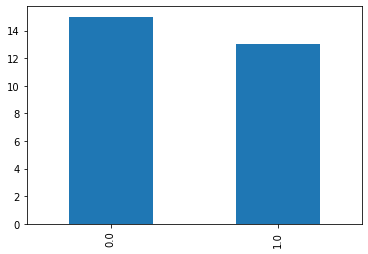

In [73]:
ax=df.Score.value_counts().plot(kind='bar')
fig = ax.get_figure()
fig.savefig("score.png");

In [75]:
df.head(10)

,Sentence,Score
0,divulguer les donnees personnelles,0.0
1,divulguer des donnees concernant ses Utilisate...,1.0
2,vous acceptez que nous puissions egalement par...,1.0
3,utiliser vos informations afin de vous informe...,1.0
4,Partage et divulgation des informations result...,0.0
5,Nous ne partageons pas vos donnees personnelle...,1.0
6,Il est possible que des entreprises utilise le...,0.0
7,Conformement � la loi n�78-17 du 6 janvier 197...,1.0
8,partagera des information personnelle avec des...,0.0
9,�tre amene � partager vos Informations personn...,1.0


In [76]:
var=df.Score.value_counts()
print(var)

0.0    15
1.0    13
Name: Score, dtype: int64


Entrainement sur un meme nombre d'échantillons + et -

In [77]:
train_pos_df=df[df.Score==1][:13]
train_neg_df=df[df.Score==0][:13]

In [67]:
train_df=train_pos_df.append(train_neg_df)
train_df.shape


(26, 2)

# SPACY

Chaque langue est différente et a des règles spécifiques, Spacy propose 8 modèles de langues différents
la 1ere etape etant la Tokenisation: c'est-à-dire à décomposer les paragraphes en phrases, puis en phrases, mots, ponctuations, etc
Les termes CGU à classifier sont en français, on se doit donc de charger un modele spacy français 


In [11]:
!python -m spacy download fr_core_news_sm

You should consider upgrading via the 'pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the model via spacy.load('fr_core_news_sm')


In [12]:
import spacy


nlp = spacy.load('fr_core_news_sm')


Dans ce qui suit quelques tests pour mettre en evidence certains resultats avant de l'appliquer sur un plus grand volume de données.

In [250]:
spacy_tok = spacy.load('fr_core_news_sm')

In [80]:

sample_review=df.Sentence[5]
sample_review

'Nous ne partageons pas vos donnees personnelles avec les publicitaires tiers ou les regies publicitaires � des fins de publicite sans votre consentement distinct '

In [81]:
parsed_review = spacy_tok(sample_review)
parsed_review

Nous ne partageons pas vos donnees personnelles avec les publicitaires tiers ou les regies publicitaires � des fins de publicite sans votre consentement distinct 

Marquage des CGU:
Après la tokenisation, nous pouvons analyser et étiqueter diverses parties de nos phrases dans le texte d'un paragraphe. SpaCy utilise des modèles statistiques en arrière-plan pour prédire quelle balise ira pour chaque mot en fonction du contexte.


In [87]:
 tokenized_text = pd.DataFrame()

for i, token in enumerate(parsed_review):
    tokenized_text.loc[i, 'text'] = token.text
    tokenized_text.loc[i, 'lemma'] = token.lemma_,
    tokenized_text.loc[i, 'pos'] = token.pos_
    tokenized_text.loc[i, 'tag'] = token.tag_
    tokenized_text.loc[i, 'dep'] = token.dep_
    tokenized_text.loc[i, 'shape'] = token.shape_
    tokenized_text.loc[i, 'is_alpha'] = token.is_alpha
    tokenized_text.loc[i, 'is_stop'] = token.is_stop
    tokenized_text.loc[i, 'is_punctuation'] = token.is_punct

tokenized_text[:20]

,text,lemma,pos,tag,dep,shape,is_alpha,is_stop,is_punctuation
0,Nous,nous,PRON,PRON__Number=Plur|Person=1,nsubj,Xxxx,True,True,False
1,ne,"(ne,)",ADV,ADV__Polarity=Neg,advmod,xx,True,True,False
2,partageons,"(partager,)",VERB,VERB__Mood=Ind|Number=Plur|Person=1|Tense=Fut|...,ROOT,xxxx,True,False,False
3,pas,"(pas,)",ADV,ADV__Polarity=Neg,advmod,xxx,True,True,False
4,vos,"(votre,)",DET,DET__Number=Plur|Poss=Yes,nmod:poss,xxx,True,True,False
5,donnees,"(donnee,)",NOUN,NOUN__Gender=Fem|Number=Plur,obj,xxxx,True,False,False
6,personnelles,"(personnel,)",ADJ,ADJ__Number=Plur,amod,xxxx,True,False,False
7,avec,"(avec,)",ADP,ADP___,case,xxxx,True,True,False
8,les,"(le,)",DET,DET__Definite=Def|Number=Plur|PronType=Art,det,xxx,True,True,False
9,publicitaires,"(publicitaire,)",NOUN,NOUN__Gender=Fem|Number=Plur,amod,xxxx,True,False,False


In [88]:
listAf = list(parsed_review.sents)
listAf

[Nous ne partageons pas vos donnees personnelles avec les publicitaires tiers ou les regies publicitaires � des fins de publicite sans votre consentement distinct]

In [89]:
displacy.render(parsed_review, style='dep', jupyter=True,options={'distance': 100})

In [90]:
spacy.displacy.render(parsed_review, style='ent', jupyter=True)

In [91]:
spacy.explain('CARDINAL') # to explain POS tag

'Numerals that do not fall under another type'

In [92]:
sentence_spans = list(parsed_review.sents)
sentence_spans

[Nous ne partageons pas vos donnees personnelles avec les publicitaires tiers ou les regies publicitaires � des fins de publicite sans votre consentement distinct]

L'analyse de dépendance est un processus d'identification de texte et de leur attribuer une structure syntaxique. Spacy fournit un arbre d'analyse qui peut être utilisé pour générer cette structure.

In [93]:
options = {'compact': True, 'bg': 'violet','distance': 140,
           'color': 'white', 'font': 'Trebuchet MS'}
displacy.render(parsed_review, jupyter=True, style='dep', options=options)

In [94]:
spacy.explain("ADJ") ,spacy.explain("det") ,spacy.explain("ADP") ,spacy.explain("prep")  # to understand tags

('adjective', 'determiner', 'adposition', 'prepositional modifier')

In [95]:
noun_chunks_df = pd.DataFrame()

for i, chunk in enumerate(parsed_review.noun_chunks):
    noun_chunks_df.loc[i, 'text'] = chunk.text
    noun_chunks_df.loc[i, 'root'] = chunk.root,
    noun_chunks_df.loc[i, 'root.text'] = chunk.root.text,
    noun_chunks_df.loc[i, 'root.dep_'] = chunk.root.dep_
    noun_chunks_df.loc[i, 'root.head.text'] = chunk.root.head.text

noun_chunks_df[:20]

,text,root,root.text,root.dep_,root.head.text
0,Nous,Nous,Nous,nsubj,partageons
1,vos donnees personnelles avec les publicitaire...,"(donnees,)","(donnees,)",obj,partageons
2,des fins de publicite,"(fins,)","(fins,)",obj,�


In [96]:
df.head() 

,Sentence,Score
0,divulguer les donnees personnelles,0.0
1,divulguer des donnees concernant ses Utilisate...,1.0
2,vous acceptez que nous puissions egalement par...,1.0
3,utiliser vos informations afin de vous informe...,1.0
4,Partage et divulgation des informations result...,0.0


In [97]:
nlp2 = spacy.load('fr_core_news_sm',disable_pipes=["tagger","parser","ner"])




In [98]:
print (nlp2)

In [99]:
doc = nlp2("partagera des information personnelle avec des tiers à des fins de marketing")
for token in doc:
    print(token.text, token.tag_, token.lemma_, token.ent_type_)

partagera VERB__Mood=Ind|Number=Sing|Person=3|Tense=Fut|VerbForm=Fin partager 
des DET__Definite=Ind|Number=Plur|PronType=Art un 
information NOUN__Gender=Fem|Number=Sing information 
personnelle ADJ__Gender=Fem|Number=Sing personnel 
avec ADP___ avec 
des DET__Definite=Ind|Number=Plur|PronType=Art un 
tiers NOUN__Gender=Masc|Number=Plur tiers 
à ADP___ à 
des DET__Definite=Ind|Number=Plur|PronType=Art un 
fins NOUN__Number=Plur fin 
de ADP___ de 
marketing NOUN__Gender=Fem|Number=Sing marketing 


In [100]:
for ent in doc.ents:
    print(ent.text, ent.label_)

In [101]:
from spacy import displacy

displacy.render(doc, style="ent")

/Users/chanez/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


Application de spacy et traitement sur tous le dictionnaire 

In [102]:
train_df['parsed'] = df.Sentence.apply(nlp2)

In [103]:
train_df.head(10)

,Sentence,Score,parsed
1,divulguer des donnees concernant ses Utilisate...,1.0,"(divulguer, des, donnees, concernant, ses, Uti..."
2,vous acceptez que nous puissions egalement par...,1.0,"(vous, acceptez, que, nous, puissions, egaleme..."
3,utiliser vos informations afin de vous informe...,1.0,"(utiliser, vos, informations, afin, de, vous, ..."
5,Nous ne partageons pas vos donnees personnelle...,1.0,"(Nous, ne, partageons, pas, vos, donnees, pers..."
7,Conformement � la loi n�78-17 du 6 janvier 197...,1.0,"(Conformement, �, la, loi, n, �, 78, -, 17, du..."
9,�tre amene � partager vos Informations personn...,1.0,"(�, tre, amene, �, partager, vos, Informations..."
11,Nous ne communiquons des donnees personnelles ...,1.0,"(Nous, ne, communiquons, des, donnees, personn..."
12,Nous ne communiquons des donnees personnelles ...,1.0,"(Nous, ne, communiquons, des, donnees, personn..."
14,"""Nous pourrons egalement partager certaines in...",1.0,"("", Nous, pourrons, egalement, partager, certa..."
20,"De plus, nous pouvons divulguer vos informatio...",1.0,"(De, plus, ,, nous, pouvons, divulguer, vos, i..."


In [105]:
train_df[-5:]

,Sentence,Score,parsed
18,Si les droits de propriete ou le\ncontr�le d�u...,0.0,"(Si, les, droits, de, propriete, ou, le, \n, c..."
22,"Possibilite � d�utiliser, copier, modifier, di...",0.0,"(Possibilite, �, d, �, utiliser, ,, copier, ,,..."
23,Nous\ntirons parti de toutes les informations ...,0.0,"(Nous, \n, tirons, parti, de, toutes, les, inf..."
24,� Toutes les donnees � caract�re personnel tra...,0.0,"(�, Toutes, les, donnees, �, caract, �, re, pe..."
27,Nos serveurs enregistrent automatiquement les ...,0.0,"(Nos, serveurs, enregistrent, automatiquement,..."


In [114]:
train_df['tuples'] = train_df.apply(
    lambda row: (row['Sentence'],row['Score']), axis=1)
train = train_df['tuples'].tolist()
train

[('divulguer des donnees concernant ses Utilisateurs si cette divulgation est raisonnablement necessaire pour faire valoir le respect',
  1.0),
 ('vous acceptez que nous puissions egalement partager des informations avec des tiers (y compris ceux dans les secteurs de l alimentation, des boissons, des loisirs, du marketing et de la publicite',
  1.0),
 ('utiliser vos informations afin de vous informer sur les biens et services qui peuvent vous interesser (par courrier, telephone , messagerie mobile (par exemple SMS, MMS , etc.) et/ou e-mail).',
  1.0),
 ('Nous ne partageons pas vos donnees personnelles avec les publicitaires tiers ou les regies publicitaires � des fins de publicite sans votre consentement distinct ',
  1.0),
 ('Conformement � la loi n�78-17 du 6 janvier 1978, l accord des Membres pour toute transmission de ses donnees � des partenaires commerciaux pour des operations de marketing  � cocher.',
  1.0),
 ('�tre amene � partager vos Informations personnelles (sauf votre car

In [115]:
train_df.head()

,Sentence,Score,parsed,tuples
1,divulguer des donnees concernant ses Utilisate...,1.0,"(divulguer, des, donnees, concernant, ses, Uti...",(divulguer des donnees concernant ses Utilisat...
2,vous acceptez que nous puissions egalement par...,1.0,"(vous, acceptez, que, nous, puissions, egaleme...",(vous acceptez que nous puissions egalement pa...
3,utiliser vos informations afin de vous informe...,1.0,"(utiliser, vos, informations, afin, de, vous, ...",(utiliser vos informations afin de vous inform...
5,Nous ne partageons pas vos donnees personnelle...,1.0,"(Nous, ne, partageons, pas, vos, donnees, pers...",(Nous ne partageons pas vos donnees personnell...
7,Conformement � la loi n�78-17 du 6 janvier 197...,1.0,"(Conformement, �, la, loi, n, �, 78, -, 17, du...",(Conformement � la loi n�78-17 du 6 janvier 19...


# Classification ML 



Dans cette partie,nous allons former un classificateur de texte CNN multi-étiquettes sur nos phrases CGU, en utilisant le composant TextCategorizer de spaCy.



In [108]:
nlp = spacy.load('fr_core_news_sm')

In [122]:

#functions from spacy documentation
def load_data(limit=0, split=0.8):
    train_data = train
    np.random.shuffle(train_data)
    train_data = train_data[-limit:]
    texts, labels = zip(*train_data)
    cats = [{'Securite': bool(y)} for y in labels]
    split = int(len(train_data) * split)
    return (texts[:split], cats[:split]), (texts[split:], cats[split:])

def evaluate(tokenizer, textcat, texts, cats):
    docs = (tokenizer(text) for text in texts)
    tp = 1e-2  # True positives
    fp = 1e-2 # False positives
    fn = 1e-2  # False negatives
    tn = 1e-2  # True negatives
    for i, doc in enumerate(textcat.pipe(docs)):
        gold = cats[i]
        for label, score in doc.cats.items():
            if label not in gold:
                continue
            if score >= 0.5 and gold[label] >= 0.5:
                tp += 1.
            elif score >= 0.5 and gold[label] < 0.5:
                fp += 1.
            elif score < 0.5 and gold[label] < 0.5:
                tn += 1
            elif score < 0.5 and gold[label] >= 0.5:
                fn += 1
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f_score = 2 * (precision * recall) / (precision + recall)
    return {'textcat_p': precision, 'textcat_r': recall, 'textcat_f': f_score}

#("Number of texts to train from","t" , int)
n_texts=1960
#You can increase texts count if you have more computational power.

#("Number of training iterations", "n", int))
n_iter=10

In [254]:
# add the text classifier to the pipeline if it doesn't exist
# nlp.create_pipe works for built-ins that are registered with spaCy
if 'textcat' not in nlp.pipe_names:
    textcat = nlp.create_pipe('textcat')
    nlp.add_pipe(textcat, last=True)
# otherwise, get it, so we can add labels to it
else:
    textcat = nlp.get_pipe('textcat')

# add label to text classifier
textcat.add_label('Securite')

# load the dataset
print("Chargement des CGU...")
(train_texts, train_cats), (dev_texts, dev_cats) = load_data(limit=n_texts)
print("utilisation de {} exemples ({} training, {} evaluation)"
      .format(n_texts, len(train_texts), len(dev_texts)))
train_data = list(zip(train_texts,
                      [{'cats': cats} for cats in train_cats]))

Chargement des CGU...
utilisation de 1960 exemples (20 training, 6 evaluation)


Entrainement du modele 


In [124]:

# get names of other pipes to disable them during training
other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'textcat']
with nlp.disable_pipes(*other_pipes):  # only train textcat
    optimizer = nlp.begin_training()
    print("Training the model...")
    print('{:^5}\t{:^5}\t{:^5}\t{:^5}'.format('LOSS', 'P', 'R', 'F'))
    for i in range(n_iter):
        losses = {}
        # batch up the examples using spaCy's minibatch
        batches = minibatch(train_data, size=compounding(4., 32., 1.001))
        for batch in batches:
            texts, annotations = zip(*batch)
            nlp.update(texts, annotations, sgd=optimizer, drop=0.2,
                       losses=losses)
        with textcat.model.use_params(optimizer.averages):
            # evaluate on the dev data split off in load_data()
            scores = evaluate(nlp.tokenizer, textcat, dev_texts, dev_cats)
        print('{0:.3f}\t{1:.3f}\t{2:.3f}\t{3:.3f}'  # print a simple table
              .format(losses['textcat'], scores['textcat_p'],
                      scores['textcat_r'], scores['textcat_f']))

Training the model...
LOSS 	  P  	  R  	  F  
0.048	0.998	0.998	0.998
0.036	0.998	0.998	0.998
0.032	0.998	0.998	0.998
0.022	0.998	0.998	0.998
0.014	0.998	0.998	0.998
0.009	0.998	0.998	0.998
0.012	0.998	0.998	0.998
0.005	0.998	0.998	0.998
0.012	0.998	0.998	0.998
0.001	0.998	0.998	0.998


In [157]:
df.iloc[[10]]

,Sentence,Score
11,Nous ne communiquons des donnees personnelles ...,1.0


Import de nouvelles données ...

In [158]:
import pandas as pd

data = pd.read_csv(r"/Users/chanez/Downloads/datasetV1.csv",header=1,error_bad_lines=False,engine='python',delimiter = ';',index_col = False,names=["Site","Clause CGU"])
data.shape

(20, 2)

In [159]:
data['docsplit']=data['Clause CGU'].apply(lambda row : nlp(str(row)))

In [160]:
data['Prediction1']=data['docsplit'].apply(lambda row : (row.cats))

In [161]:
data['Prediction2']=data['Prediction1'].apply(lambda row : str(row))

In [162]:
data.head(10)

,Site,Clause CGU,docsplit,Prediction1,Prediction2
0,light in marketing,Dans le cadre de la mise a disposition de notr...,"(Dans, le, cadre, de, la, mise, a, disposition...",{'Securite': 0.7556806802749634},{'Securite': 0.7556806802749634}
1,Fnac,Les donnees personnelles collectees dans le ca...,"(Les, donnees, personnelles, collectees, dans,...",{'Securite': 0.6106873750686646},{'Securite': 0.6106873750686646}
2,Darty,Les informations et donne_es Vous concernant s...,"(Les, informations, et, donne_es, Vous, concer...",{'Securite': 0.9216602444648743},{'Securite': 0.9216602444648743}
3,Ma banque,Conforme_ment � la loi du 6 janvier 1978 modif...,"(Conforme_ment, �, la, loi, du, 6, janvier, 19...",{'Securite': 0.18354755640029907},{'Securite': 0.18354755640029907}
4,Pole Emploi,Les donnees a caractere personnel sont collect...,"(Les, donnees, a, caractere, personnel, sont, ...",{'Securite': 0.2705214023590088},{'Securite': 0.2705214023590088}
5,Appel,Les donnees personnelles que nous recueillons ...,"(Les, donnees, personnelles, que, nous, recuei...",{'Securite': 0.9409632086753845},{'Securite': 0.9409632086753845}
6,Ikea,Ces donnees seront conservees uniquement le te...,"(Ces, donnees, seront, conservees, uniquement,...",{'Securite': 0.20461496710777283},{'Securite': 0.20461496710777283}
7,Conforama,Elles sont utilisees principalement pour le tr...,"(Elles, sont, utilisees, principalement, pour,...",{'Securite': 0.7961626648902893},{'Securite': 0.7961626648902893}
8,Noeness,Certaines informations demandees dans nos form...,"(Certaines, informations, demandees, dans, nos...",{'Securite': 0.641991138458252},{'Securite': 0.641991138458252}
9,Louis Vuitton,Nous recueillons des donnees personnelles vous...,"(Nous, recueillons, des, donnees, personnelles...",{'Securite': 0.6496886610984802},{'Securite': 0.6496886610984802}


In [163]:
indesirable="{}:'Securite "
indesirable

"{}:'Securite "

In [164]:
def remove_indesirable(text):
    new_text= ''.join([word for word in text if word not in indesirable])
    return new_text

In [165]:
data['Prediction3']=data['Prediction2'].apply(lambda row : remove_indesirable(row))

In [232]:
data['Prediction']=data['Prediction3'].apply(lambda row : "%.2f" %(float(row)))

In [125]:
test_text1 = 'partagera des information personnelle avec des tiers à des fins de marketing'
doc = nlp(test_text1)
print(doc)
test_text1, doc.cats

partagera des information personnelle avec des tiers à des fins de marketing


('partagera des information personnelle avec des tiers à des fins de marketing',
 {'Securite': 0.04079314321279526})

In [233]:
data.head(10)

,Site,Clause CGU,docsplit,Prediction1,Prediction2,Prediction3,Prediction
0,light in marketing,Dans le cadre de la mise a disposition de notr...,"(Dans, le, cadre, de, la, mise, a, disposition...",{'Securite': 0.7556806802749634},{'Securite': 0.7556806802749634},0.7556806802749634,0.76
1,Fnac,Les donnees personnelles collectees dans le ca...,"(Les, donnees, personnelles, collectees, dans,...",{'Securite': 0.6106873750686646},{'Securite': 0.6106873750686646},0.6106873750686646,0.61
2,Darty,Les informations et donne_es Vous concernant s...,"(Les, informations, et, donne_es, Vous, concer...",{'Securite': 0.9216602444648743},{'Securite': 0.9216602444648743},0.9216602444648743,0.92
3,Ma banque,Conforme_ment � la loi du 6 janvier 1978 modif...,"(Conforme_ment, �, la, loi, du, 6, janvier, 19...",{'Securite': 0.18354755640029907},{'Securite': 0.18354755640029907},0.18354755640029907,0.18
4,Pole Emploi,Les donnees a caractere personnel sont collect...,"(Les, donnees, a, caractere, personnel, sont, ...",{'Securite': 0.2705214023590088},{'Securite': 0.2705214023590088},0.2705214023590088,0.27
5,Appel,Les donnees personnelles que nous recueillons ...,"(Les, donnees, personnelles, que, nous, recuei...",{'Securite': 0.9409632086753845},{'Securite': 0.9409632086753845},0.9409632086753845,0.94
6,Ikea,Ces donnees seront conservees uniquement le te...,"(Ces, donnees, seront, conservees, uniquement,...",{'Securite': 0.20461496710777283},{'Securite': 0.20461496710777283},0.20461496710777283,0.20
7,Conforama,Elles sont utilisees principalement pour le tr...,"(Elles, sont, utilisees, principalement, pour,...",{'Securite': 0.7961626648902893},{'Securite': 0.7961626648902893},0.7961626648902893,0.80
8,Noeness,Certaines informations demandees dans nos form...,"(Certaines, informations, demandees, dans, nos...",{'Securite': 0.641991138458252},{'Securite': 0.641991138458252},0.641991138458252,0.64
9,Louis Vuitton,Nous recueillons des donnees personnelles vous...,"(Nous, recueillons, des, donnees, personnelles...",{'Securite': 0.6496886610984802},{'Securite': 0.6496886610984802},0.6496886610984802,0.65


In [126]:
test_text2 = 'De plus, nous pouvons divulguer vos informations personnelles dans le cadre d une transaction d entreprise, comme une fusion ou la vente de nos actifs. '
doc = nlp(test_text2)
test_text2, doc.cats

('De plus, nous pouvons divulguer vos informations personnelles dans le cadre d une transaction d entreprise, comme une fusion ou la vente de nos actifs. ',
 {'Securite': 0.9883978962898254})

In [132]:

output_dir='/Users/chanez/Downloads/CGU_V1'
nlp.to_disk(output_dir)
print("Saved model to", output_dir)

Saved model to /Users/chanez/Downloads/CGU_V1


In [135]:
var=nlp.from_disk(output_dir)


In [136]:
test_text3 = 'Si la structure de notre entreprise devait evoluer, par le biais d une fusion, acquisition par une autre societe, vente de tout ou partie des activites, les Informations personnelles figureraient probablement parmi les actifs transferes. '
doc = var(test_text3)
test_text3, doc.cats

('Si la structure de notre entreprise devait evoluer, par le biais d une fusion, acquisition par une autre societe, vente de tout ou partie des activites, les Informations personnelles figureraient probablement parmi les actifs transferes. ',
 {'Securite': 0.007112880237400532})

In [137]:

export_csv = df.to_csv (r'/Users/chanez/Downloads/CGU_V1.csv', index = None, header=True,sep=';', encoding='utf-8') #Don't forget to add '.csv' at the end of the path\n"

d


In [148]:
train_df.head(10)

,Sentence,Score,parsed,tuples
1,divulguer des donnees concernant ses Utilisate...,1.0,"(divulguer, des, donnees, concernant, ses, Uti...",(divulguer des donnees concernant ses Utilisat...
2,vous acceptez que nous puissions egalement par...,1.0,"(vous, acceptez, que, nous, puissions, egaleme...",(vous acceptez que nous puissions egalement pa...
3,utiliser vos informations afin de vous informe...,1.0,"(utiliser, vos, informations, afin, de, vous, ...",(utiliser vos informations afin de vous inform...
5,Nous ne partageons pas vos donnees personnelle...,1.0,"(Nous, ne, partageons, pas, vos, donnees, pers...",(Nous ne partageons pas vos donnees personnell...
7,Conformement � la loi n�78-17 du 6 janvier 197...,1.0,"(Conformement, �, la, loi, n, �, 78, -, 17, du...",(Conformement � la loi n�78-17 du 6 janvier 19...
9,�tre amene � partager vos Informations personn...,1.0,"(�, tre, amene, �, partager, vos, Informations...",(�tre amene � partager vos Informations person...
11,Nous ne communiquons des donnees personnelles ...,1.0,"(Nous, ne, communiquons, des, donnees, personn...",(Nous ne communiquons des donnees personnelles...
12,Nous ne communiquons des donnees personnelles ...,1.0,"(Nous, ne, communiquons, des, donnees, personn...",(Nous ne communiquons des donnees personnelles...
14,"""Nous pourrons egalement partager certaines in...",1.0,"("", Nous, pourrons, egalement, partager, certa...","(""Nous pourrons egalement partager certaines i..."
20,"De plus, nous pouvons divulguer vos informatio...",1.0,"(De, plus, ,, nous, pouvons, divulguer, vos, i...","(De plus, nous pouvons divulguer vos informati..."


In [239]:
pd.to_numeric(data.Prediction, downcast='float')

0     0.76
1     0.61
2     0.92
3     0.18
4     0.27
5     0.94
6     0.20
7     0.80
8     0.64
9     0.65
10    0.57
11    0.70
12    0.93
13    0.98
14    0.67
15    0.64
16    0.91
17    0.59
18    0.89
19    0.61
Name: Prediction, dtype: float32

data.head(10)

In [248]:
data.head(10)

,Site,Clause CGU,docsplit,Prediction1,Prediction2,Prediction3,Prediction
0,light in marketing,Dans le cadre de la mise a disposition de notr...,"(Dans, le, cadre, de, la, mise, a, disposition...",{'Securite': 0.7556806802749634},{'Securite': 0.7556806802749634},0.7556806802749634,0.76
1,Fnac,Les donnees personnelles collectees dans le ca...,"(Les, donnees, personnelles, collectees, dans,...",{'Securite': 0.6106873750686646},{'Securite': 0.6106873750686646},0.6106873750686646,0.61
2,Darty,Les informations et donne_es Vous concernant s...,"(Les, informations, et, donne_es, Vous, concer...",{'Securite': 0.9216602444648743},{'Securite': 0.9216602444648743},0.9216602444648743,0.92
3,Ma banque,Conforme_ment � la loi du 6 janvier 1978 modif...,"(Conforme_ment, �, la, loi, du, 6, janvier, 19...",{'Securite': 0.18354755640029907},{'Securite': 0.18354755640029907},0.18354755640029907,0.18
4,Pole Emploi,Les donnees a caractere personnel sont collect...,"(Les, donnees, a, caractere, personnel, sont, ...",{'Securite': 0.2705214023590088},{'Securite': 0.2705214023590088},0.2705214023590088,0.27
5,Appel,Les donnees personnelles que nous recueillons ...,"(Les, donnees, personnelles, que, nous, recuei...",{'Securite': 0.9409632086753845},{'Securite': 0.9409632086753845},0.9409632086753845,0.94
6,Ikea,Ces donnees seront conservees uniquement le te...,"(Ces, donnees, seront, conservees, uniquement,...",{'Securite': 0.20461496710777283},{'Securite': 0.20461496710777283},0.20461496710777283,0.20
7,Conforama,Elles sont utilisees principalement pour le tr...,"(Elles, sont, utilisees, principalement, pour,...",{'Securite': 0.7961626648902893},{'Securite': 0.7961626648902893},0.7961626648902893,0.80
8,Noeness,Certaines informations demandees dans nos form...,"(Certaines, informations, demandees, dans, nos...",{'Securite': 0.641991138458252},{'Securite': 0.641991138458252},0.641991138458252,0.64
9,Louis Vuitton,Nous recueillons des donnees personnelles vous...,"(Nous, recueillons, des, donnees, personnelles...",{'Securite': 0.6496886610984802},{'Securite': 0.6496886610984802},0.6496886610984802,0.65


In [247]:
del data['Prediction %']

# Data Visualisation

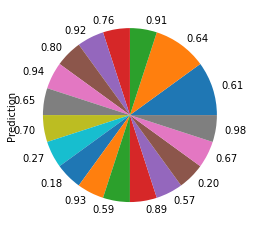

In [257]:
data['Prediction'].value_counts().plot.pie()


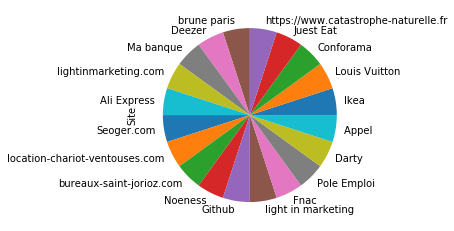

In [258]:
data['Site'].value_counts().plot.pie()

Export des resultats prédis 

In [246]:
export_csv = data.to_csv (r'/Users/chanez/Downloads/resultat_prediction2.csv', index = None, header=True,sep=';', encoding='utf-8') #Don't forget to add '.csv' at the end of the path\n"
